In [1]:
import matplotlib.pyplot as plt
import ML_library        as MLL
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os
import torch
import json

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In this notebook you are able to load a pre-trained model for predicting the lattice contribution to the free-energy and use it to predict this property over an input database. The model $GCNN$ predicts the lattice contribution to the free-energy $F_v(m, T) = GCNN(m, T)$ for material $m$ at temperature $T$. Then, knowing the ground-state energy of material $m$, $E_0 (m)$, the Helmholtz free-energy would be $F(m, T) = E_0 (m) + F_v(m, T)$. Importantly, this approach disregards any other contribution to the free-energy that just vibrational. Metallic materials should be avoided.

The baseline pretrained model has been trained in the 100 to 700 K temperature range, thus it will likely be more efficient in this range. It is recomended predicting within the 200 to 600 K range in order to avoid the misbehaviour of $C_p$ at high temperature.

We implemented a tool which allows estimating the quality of the predicted free energy regarding 1) the chemistry of the target material and 2) the temperature at which the prediction is made. This approach is valid for any other input model, as it directly checks the proximity of the hyper-representation that the GCNN creates for the target material and this from any known accurate prediction.

Ferromagnetic transitions are estimated based on pure geometrical reasong, predicted as any transition involving a non-centrosymmmetric space group.

# Define parameters

In [2]:
model_folder    = '/home/claudio/cibran/Work/UPC/MP/models/Fv-accurate-fulldata'  # Path to the folder containing model and dataset parameters
target_database = 'Loaded_PhaseTransition'  # Where the target database is located

# Whether to plot the harmonic extrapolations of Fv (very time-consuming) or not
plot_extrapolations = False

# Defining the range of temperatures
Ti = 300
Tf = 600
dT = 50
temperatures = np.arange(Ti, Tf+dT, dT)  # Temperatures for prediction of free-energies

# dpi for saved images (histograms and harmonic extrapolations if plot_extrapolations set to True)
dpi = 50

# Importing the list of non-centrosymmetric space groups
non_centrosymmetric_space_groups = np.loadtxt('input/non-centrosymmetric-phases.txt', dtype='str')

# Loading dictionary of atomic masses
atomic_masses = {}
with open('input/atomic_masses.dat', 'r') as atomic_masses_file:
    for line in atomic_masses_file:
        (key, mass, _, _, _) = line.split()
        atomic_masses[key] = mass

# Perform predictions

For the sake of optimization, we first predict all the free-energies in the target database. For that, we read the parameters we need for standardizing the target dataset, load the pre-trained model, perform the predictions and smooth those with a fitting to a fourth-order polynomial with respect to temperature.

In [3]:
# Load the data from the JSON file
with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Create dataset for predictions
dataset, labels = MLL.create_predictions_dataset(target_database)

# Standardize properties
dataset = MLL.standarize_dataset(dataset, standardized_parameters, transformation=standardized_parameters['transformation'])

# Include temperatures
pred_dataset = MLL.include_temperatures(dataset, temperatures, standardized_parameters)

torch.save(pred_dataset, 'pred_dataset.pt')
torch.save(labels,       'labels.pt')

RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 9551780992 vs 9551780908

In [3]:
# Approach: we will generate full pred_dataset, save it and re-start kernel. Then, load it and  continue









# Load the data from the JSON file
with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Load Graph Neural Network model (making room for temperature as node attribute) to device
# Dropout for initializing the model, not used at all while predicting
model = MLL.GCNN(features_channels=4+1,
                 pdropout=0.3).to(device)

# Load and evaluate Graph Neural Network model
model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(device)))
model.eval()

reference_dataset = torch.load('/home/claudio/Desktop/reference_dataset.pt')
pred_dataset = torch.load('/home/claudio/Desktop/pred_dataset.pt')

/tmp/ipykernel_222855/1276327980.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(

In [ ]:
# Compute predictions and corresponding uncertainties
shot_predictions, shot_uncertainties = MLL.make_predictions(reference_dataset, pred_dataset, model, standardized_parameters)

# Computing the coefficients and uncertainties from fitting
coefficients, uncertainties = MLL.compute_coefficients(temperatures, shot_predictions, shot_uncertainties)

# Smooth predictions and read fitting parameters
predictions = MLL.compute_Fv(temperatures, coefficients)

# Computing phase transitions

Now we have already computed not only the free-energies for each material in the intended temperature range, but also the parameters of the fourth-order polynomial which smooths the predictions. With that, we can look for phase transitions for each materials presenting at least two polymorphs in the target dataset and, for those, extract transition temperature, entropy change or whether this is or not a ferroelectric transition.

In [ ]:
# Ordering by families
indexes       = np.argsort(labels)  # This way we put all the polymorphs from a same material together
labels        = np.array(labels)[indexes]
coefficients  = coefficients[:, indexes]
uncertainties = uncertainties[:, indexes]

# Separating compounds and polymorphes
compounds, polymorphs = zip(*(line.split() for line in labels))

# Reading ground state energies (energy per atom)
# From eV/atom to meV/atom
gs_energies = [float(np.loadtxt(f'{target_database}/{comp}/{poly}/EPA')) * 1e3 for comp, poly in zip(compounds, polymorphs)]

# Reading conductivities (lattice thermal conductivities)
# In W/mK
conductivities = [float(np.loadtxt(f'{target_database}/{comp}/{poly}/LTC'))
                  if os.path.isfile(f'{target_database}/{comp}/{poly}/LTC') else None for comp, poly in zip(compounds, polymorphs)]

# Unique compounds (not considering polymorphes)
unique_compounds, unique_counts = np.unique(compounds, return_counts=True)
unique_indexes = np.append([0], np.cumsum(unique_counts))  # So it starts with 0

In [ ]:
# Initializing files with data
stable_transition_phases   = []
unstable_transition_phases = []
for i, compound in enumerate(unique_compounds):
    # Getting corresponding predictions
    index1 = unique_indexes[i]
    index2 = unique_indexes[i+1]

    static_energies           = gs_energies[index1:index2]
    lattice_conductivities    = conductivities[index1:index2]
    vibrational_coefficients  = coefficients[:, index1:index2]
    vibrational_uncertainties = uncertainties[:, index1:index2]

    n_polymorphs = index2 - index1
    if n_polymorphs > 1:
        print(compound)
        if plot_extrapolations:
            fig = plt.figure(figsize=(5, 5))

        free_energies = np.array([
            static_energies[k] + MLL.Helmholtz_free_energy_function(temperatures, *vibrational_coefficients[:, k])
            for k in range(n_polymorphs)
        ])

        for k in range(n_polymorphs):
            _beta_1         = vibrational_coefficients[:, k]
            _s_beta_1       = vibrational_uncertainties[:, k]
            static_energy_1 = static_energies[k]
            LTC_1           = lattice_conductivities[k]
            free_energies_1 = free_energies[k]
            polymorph_1     = polymorphs[index1+k]

            # Determine the centrosymmetry of the phase
            non_centrosymmetric_1 = polymorph_1 in non_centrosymmetric_space_groups

            # Plotting
            if plot_extrapolations:
                # Temperature range for plotting
                temperatures_plot = np.arange(Ti, Tf+dT, 0.1)

                # Smooth Gibbs energy for plotting
                gibbs_energy_plot = static_energy_1 + MLL.Helmholtz_free_energy_function(temperatures_plot, *_beta_1)
                plt.plot(temperatures_plot, gibbs_energy_plot, label=polymorph_1)

            # Looking for phase transitions
            for m in np.arange(k+1, n_polymorphs):
                _beta_2         = vibrational_coefficients[:, m]
                _s_beta_2       = vibrational_uncertainties[:, m]
                static_energy_2 = static_energies[m]
                LTC_2           = lattice_conductivities[m]
                free_energies_2 = free_energies[m]
                polymorph_2     = polymorphs[index1+m]

                # Computing the entropy change provoked by the transition
                d_E0 = static_energy_2 - static_energy_1
                d_alpha, d_beta, d_gamma = _beta_2 - _beta_1
                s_d_alpha, s_d_beta, s_d_gamma = np.sqrt(_s_beta_1**2 + _s_beta_2**2)
                
                # We scaled parameters for fitting, so now we de-scale them
                d_beta  *= 1e-5
                d_gamma *= 1e-10

                # Two possible transition temperatures
                temp_root_1 = (-d_beta + np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
                temp_root_2 = (-d_beta - np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)

                # Filter valid transition within the temperature range of interest
                c_valid_temperatures = [x for x in [np.sqrt(temp_root_1), np.sqrt(temp_root_2)] if Ti < x < Tf]

                # Determine if there is any transition within the temperature interval
                if not len(c_valid_temperatures):  # There is not a transition between these polymorphs
                    continue
                elif len(c_valid_temperatures) > 1:
                    print(f'Warning: {len(c_valid_temperatures)} transitions within this interval')

                # Get the expected critical temperature and free energy
                c_temperature = np.min(c_valid_temperatures)
                
                # Compute partial derivatives
                partial_c_temperature_alpha = d_beta / (2 * c_temperature * (2 * d_gamma * c_temperature**2 + d_beta))
                partial_c_temperature_beta  = (d_beta**2 - 2 * d_gamma * (d_E0 + d_alpha)) / (2 * c_temperature * d_gamma * (2 * d_gamma * c_temperature**2 + d_beta))
                partial_c_temperature_gamma = (d_beta * (2 * d_E0 * d_gamma + 2 * d_alpha * d_gamma - d_beta**2)) / (2 * c_temperature * 2 * d_gamma**2 * (2 * d_gamma * c_temperature**2 + d_beta))
                
                # Compute uncertainty
                s_c_temperature = np.sqrt(s_d_alpha**2 * partial_c_temperature_alpha**2 + s_d_beta**2 * partial_c_temperature_beta**2 + s_d_gamma**2 * partial_c_temperature_gamma**2)
                
                # Compute free energy and slope changes 
                c_free_energy = static_energy_1 + MLL.Helmholtz_free_energy_function(c_temperature, *_beta_1)
                d_slope       = c_temperature * np.abs(2 * d_beta + 4 * d_gamma * c_temperature**2)
                
                # Compute partial derivatives
                partial_slope_c_temperature = 2*d_beta + 12*d_gamma*c_temperature**2
                partial_slope_d_beta        = 2*c_temperature
                partial_slope_d_gamma       = 4*c_temperature**3
                
                # Compute uncertainty
                s_d_slope = np.sqrt(s_c_temperature**2 * partial_slope_c_temperature**2 + s_d_beta**2 * partial_slope_d_beta**2 + s_d_gamma**2 * partial_slope_d_gamma**2)

                # Read atomic information for entropy change estimation
                with open(f'{target_database}/{compound}/{polymorph_1}/POSCAR', 'r') as POSCAR_file:
                    POSCAR_lines = POSCAR_file.readlines()
                composition   = POSCAR_lines[5].split()
                concentration = np.array(POSCAR_lines[6].split(), dtype=float)

                # Get atomic mass involved in the transition
                total_mass = sum(float(atomic_masses[el]) * conc for el, conc in zip(composition, concentration))

                # Compute entropy change, from meV/atomK to J/kgK (1e3 as g goes to kg)
                prefactor   = 6.022 * 1.6 * 1e4 * concentration.sum() / total_mass
                c_entropy   = d_slope * prefactor
                s_c_entropy = s_d_slope * prefactor

                # Check which has lower energy at lower temperature
                c_free_energy_1 = static_energy_1 + MLL.Helmholtz_free_energy_function(c_temperature-5, *_beta_1)
                c_free_energy_2 = static_energy_2 + MLL.Helmholtz_free_energy_function(c_temperature-5, *_beta_2)

                first_polymorph, last_polymorph = (polymorph_1, polymorph_2) if c_free_energy_1 < c_free_energy_2 else (polymorph_2, polymorph_1)
                label = f'{first_polymorph} -> {last_polymorph} ({c_temperature:.2f}K, {c_entropy:.2f} J/kgK)'
                print(label)
                
                if plot_extrapolations and len(c_valid_temperatures):
                    plt.plot(c_temperature, c_free_energy, 'o', label=label)

                # Determine the centrosymmetry of the phase
                non_centrosymmetric_2 = polymorph_2 in non_centrosymmetric_space_groups

                # 0, 1, 2 if none, one or both are centrosymmetric, respectively
                non_centrosymmetric = non_centrosymmetric_1 + non_centrosymmetric_2
                
                # Get lattice thermal conductivity change
                
                # Divide by the centrysymmetric (nonpolar) polymorph LTC
                LTC_change = None
                if non_centrosymmetric_1:
                    LTC_change = np.abs(LTC_2 - LTC_1) / LTC_2
                elif non_centrosymmetric_2:
                    LTC_change = np.abs(LTC_2 - LTC_1) / LTC_1
                else:
                    LTC_change = np.abs(LTC_2 - LTC_1) / np.min([LTC_1, LTC_2])

                # Appending information (compound name, involved phases in order,
                # temperature of transition, entropy change involved in the transition,
                # whether a non-centrosymmetric phase is involved or not, and lattice
                # thermal conductivity change)
                transition_data = {'compound': compound, 'polymorph-1': first_polymorph, 'polymorph-2': last_polymorph,
                                   'transition-temperature': c_temperature, 'transition-temperature-uncert': s_c_temperature,
                                   'entropy-change': c_entropy, 'entropy-change-uncer': s_c_entropy,
                                   'centrosymmetry': non_centrosymmetric, 'conductivity-change': LTC_change}

                min_vib_energy = min(
                    static_energies[j] + MLL.Helmholtz_free_energy_function(c_temperature, *vibrational_coefficients[:, j])
                    for j in range(n_polymorphs)
                )

                if np.isclose(c_free_energy, min_vib_energy):
                    stable_transition_phases.append(transition_data)
                else:
                    unstable_transition_phases.append(transition_data)

        if plot_extrapolations:
            plt.title(compound)
            plt.xlabel('$T$ (K)')
            plt.ylabel(r'$F_{v}$ (meV/atom)')
            plt.legend(loc=(1.05, 0.5))
            plt.savefig(f'{model_folder}/{compound}.eps', dpi=50, bbox_inches='tight')
            plt.show()

# Visualizing the results

In [34]:
# Convert to panda data-frames for easy handling
stable_transition_phases   = pd.DataFrame(stable_transition_phases)
unstable_transition_phases = pd.DataFrame(unstable_transition_phases)

## First N stable materials highest entropy changes

In [7]:
# Save to excel
df_es_stp = stable_transition_phases.sort_values(by='entropy-change', ascending=False)
df_es_stp.to_excel('High-entropy stable transitions.xlsx')
df_es_stp

,comound,polymorf-1,polymorf-2,transition-temperature,entropy-change,centrosymmetry,slope,metric-1,metric-2
70,C,Fd-3m,R-3m,596.724547,1255.816340,2,0.156547,1.366730,3.956317
313,Li3N,P6-mmm,P6_3-mmc,550.867361,1229.778709,1,0.111136,0.436180,0.212147
354,LiBeH3,C2,P-1,556.942682,1021.088628,1,0.040222,0.456183,0.169583
334,Li5BO4,Pmmn,Pbca,522.883542,884.561482,2,0.100538,0.198355,0.121416
69,C,Cmmm,Fd-3m,388.898889,837.488571,2,0.104399,0.141969,1.366730
...,...,...,...,...,...,...,...,...,...
248,La2Ge2O7,P1,P-1,461.154223,1.627428,1,0.000821,0.201646,0.237261
591,Sr2SnO4,Pccn,Cmce,304.885952,1.453859,1,0.000772,0.266807,0.476343
606,TbCuSe2,P3m1,P2_1-c,423.187676,1.134219,0,0.001119,1.370575,1.346219
148,CsPbCl3,P4-mbm,Amm2,537.459744,0.696605,1,0.000646,0.518806,0.524069


## Amount of phase transitions at each temperature interval

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


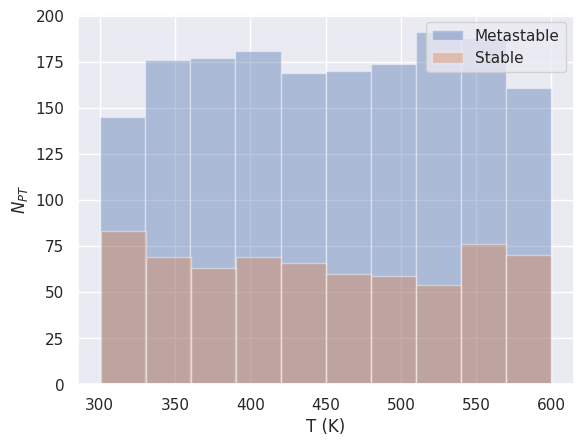

In [8]:
plt.hist(unstable_transition_phases['transition-temperature'], alpha=0.4, label='Metastable')
plt.hist(stable_transition_phases['transition-temperature'],   alpha=0.4, label='Stable')
plt.legend(loc='best')
plt.xlabel('T (K)')
plt.ylabel(r'$N_{PT}$')
plt.savefig(f'{model_folder}/Histogram_critical_temperatures.eps', dpi=dpi, bbox_inches='tight')
plt.show()

## Amount of phase transitions involving some entropy change

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


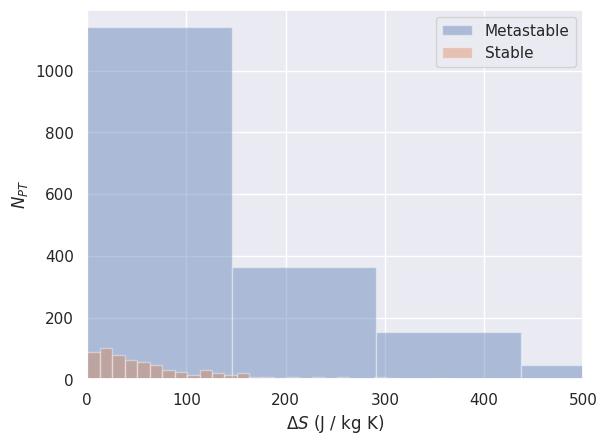

In [18]:
plt.hist(unstable_transition_phases['entropy-change'], bins=100, alpha=0.4, label='Metastable')
plt.hist(stable_transition_phases['entropy-change'],   bins=100, alpha=0.4, label='Stable')

plt.legend(loc='best')
plt.xlim(0, 500)
plt.xlabel(r'$\Delta S$ (J / kg K)')
plt.ylabel(r'$N_{PT}$')
plt.savefig(f'{model_folder}/Histogram_entropy_changes.eps', dpi=dpi, bbox_inches='tight')
plt.show()

## Amount of phase transitions in terms of centrosymmetry

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


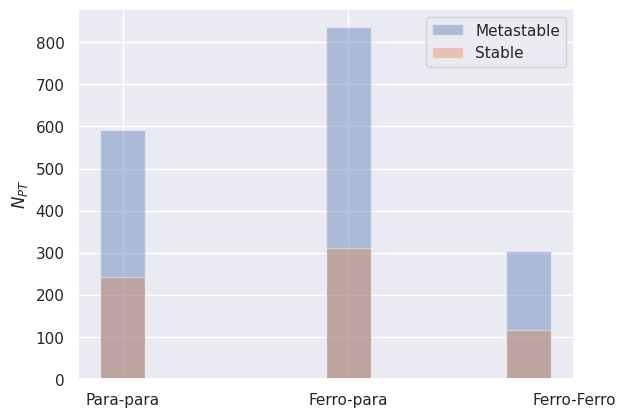

In [10]:
# Swith to type of transition
plt_unstable_non_centrosymmetry = np.array(unstable_transition_phases['centrosymmetry'], dtype=object)
plt_stable_non_centrosymmetry   = np.array(stable_transition_phases['centrosymmetry'],   dtype=object)

centrosymmetries = np.array(['Para-para', 'Ferro-para', 'Ferro-Ferro'])

for i in range(len(centrosymmetries)):
    plt_unstable_non_centrosymmetry[np.where(unstable_transition_phases['centrosymmetry'] == i)[0]] = centrosymmetries[i]
    plt_stable_non_centrosymmetry[np.where(stable_transition_phases['centrosymmetry']     == i)[0]] = centrosymmetries[i]

# Create the histogram
plt.hist(plt_unstable_non_centrosymmetry, alpha=0.4, label='Metastable', align='left')
plt.hist(plt_stable_non_centrosymmetry,   alpha=0.4, label='Stable', align='left')
plt.ylabel(r'$N_{PT}$')
plt.legend(loc='best')
plt.savefig(f'{model_folder}/Histogram_centrosymmetry.eps', dpi=dpi, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and entropy change

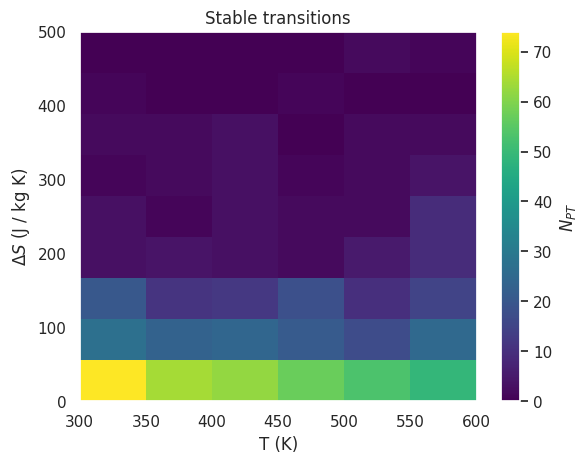

In [11]:
x_edges = temperatures
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['transition-temperature'], stable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transitions')
plt.savefig(f'{model_folder}/Temperature_vs_stable_entropy_changes.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

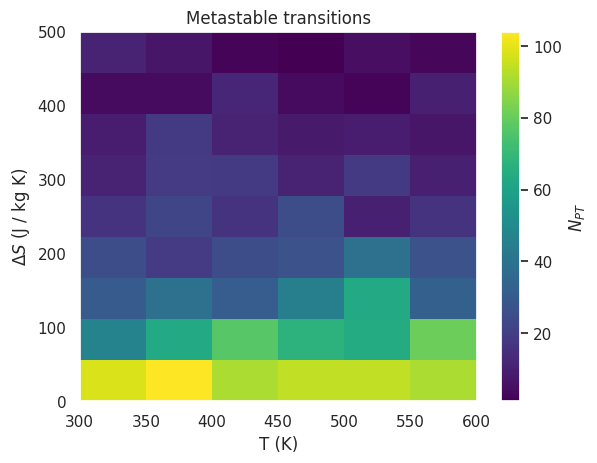

In [12]:
x_edges = temperatures
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(unstable_transition_phases['transition-temperature'], unstable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transitions')
plt.savefig(f'{model_folder}/Temperature_vs_unstable_stable_entropy_changes.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and centrosymmetries

In [13]:
# Create a mapping of strings to unique integers
centrosymmetries_dict = {'Para-para':   0,
                         'Ferro-para':  1,
                         'Ferro-Ferro': 2}
centrosymmetry_edges = [0, 0.66, 1.33, 2]
centrosymmetry_ticks_x = [0.33, 1, 1.66]
centrosymmetry_ticks_labels = ['Para-para', 'Ferro-para', 'Ferro-Ferro']

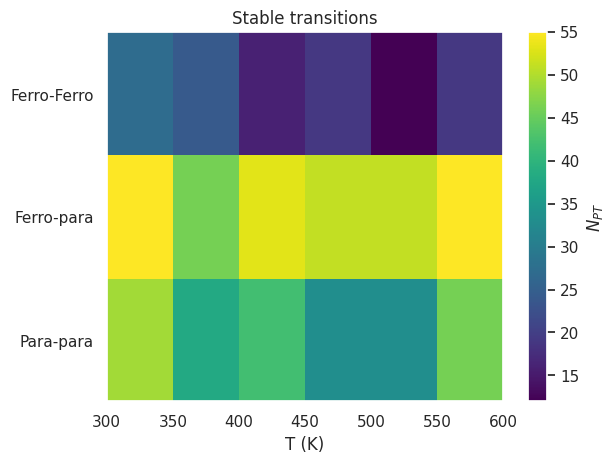

In [14]:
x_edges = temperatures
y_edges = centrosymmetry_edges

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['transition-temperature'], stable_transition_phases['centrosymmetry'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.yticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.xlabel('T (K)')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transitions')
plt.savefig(f'{model_folder}/Temperature_vs_stable_centrosymmetry.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

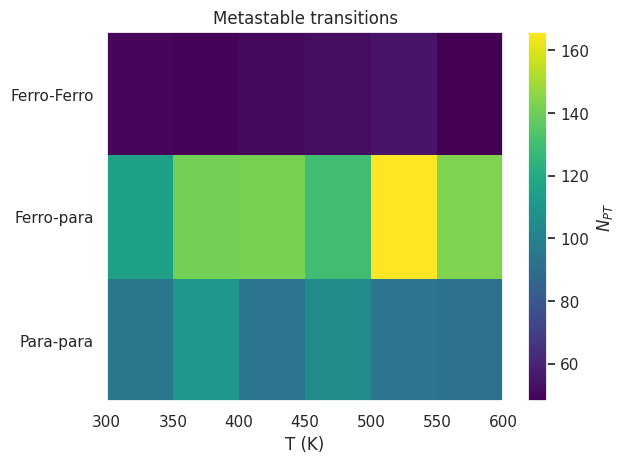

In [15]:
x_edges = temperatures
y_edges = centrosymmetry_edges

# Generate the 2D histogram data
distribution = np.histogram2d(unstable_transition_phases['transition-temperature'], unstable_transition_phases['centrosymmetry'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.yticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.xlabel('T (K)')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transitions')
plt.savefig(f'{model_folder}/Temperature_vs_unstable_centrosymmetry.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

## Amount of phase transitions with centrosymmetries and entropy change

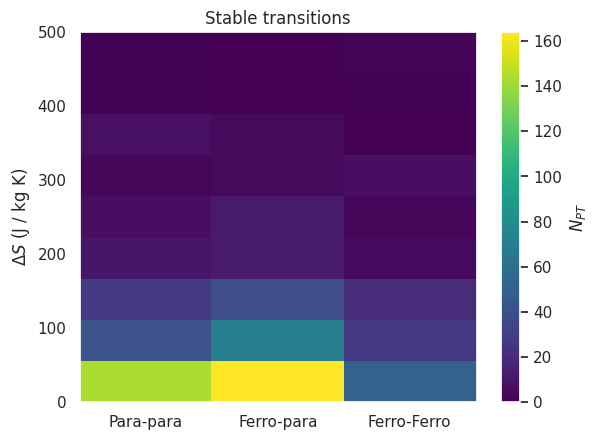

In [16]:
x_edges = centrosymmetry_edges
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['centrosymmetry'], stable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transitions')
plt.savefig(f'{model_folder}/Entropy_changes_vs_stable_centrosymmetry.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

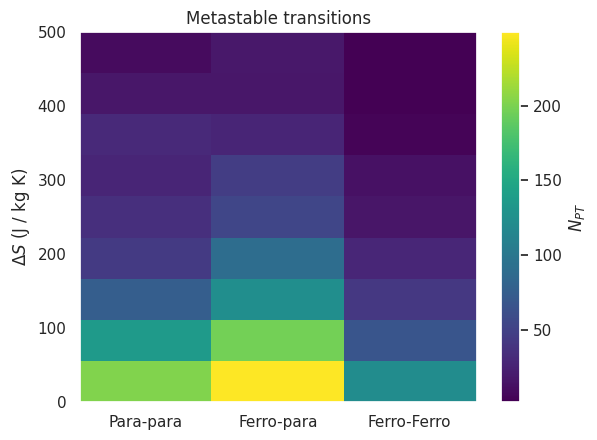

In [17]:
x_edges = centrosymmetry_edges
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(unstable_transition_phases['centrosymmetry'], unstable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transitions')
plt.savefig(f'{model_folder}/Entropy_changes_vs_unstable_centrosymmetry.pdf', dpi=dpi, bbox_inches='tight')
plt.show()